In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda, Input
from tensorflow.keras.models import Model
plt.style.use('default')
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('TSLA.csv')
print(df.shape)
df.head()

(2416, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

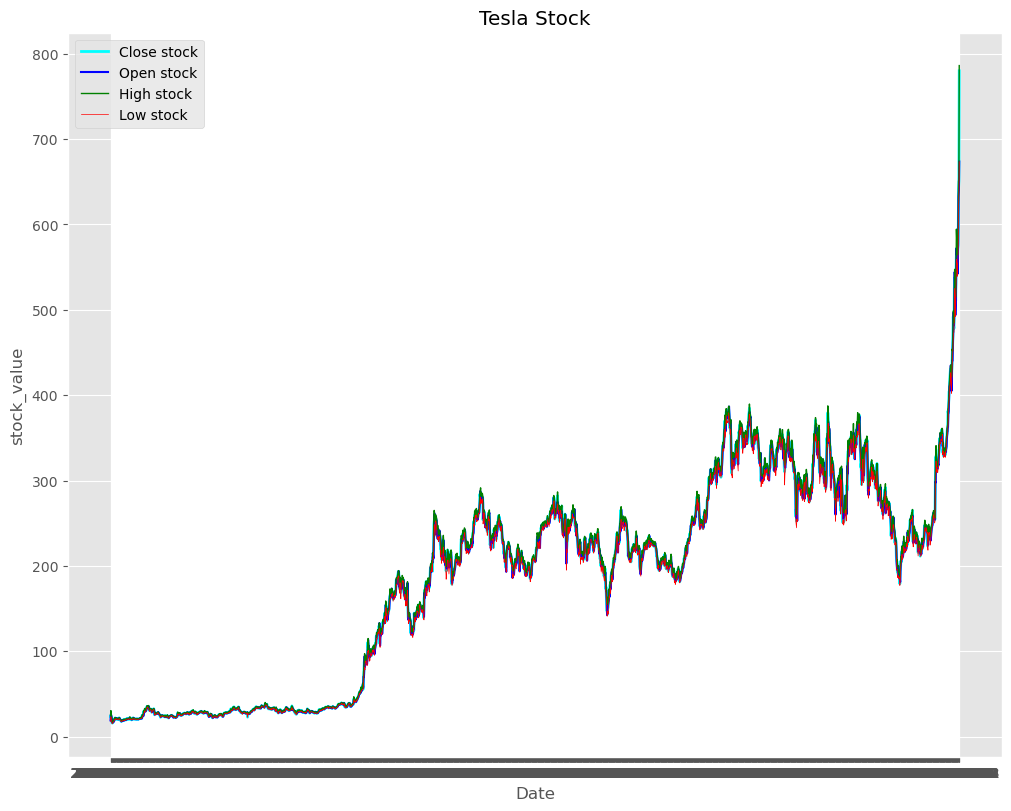

In [4]:
plt.figure(figsize=(10, 8), constrained_layout=True)
c = ['cyan', 'blue', 'green', 'red']
y = ['Close', 'Open', 'High', 'Low']
l = 2.0
for j, c in zip(y, c):
  plt.plot(df['Date'], df[j], color=c, linewidth=l, label=f'{j} stock')
  plt.title('Tesla Stock')
  plt.xlabel('Date')
  plt.ylabel('stock_value')
  plt.legend()
  l -=0.5

plt.show()

In [5]:
from PyEMD import CEEMDAN, Visualisation

In [6]:
close = df[['Close']].values

In [95]:
close

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [640.809998],
       [650.570007],
       [780.      ]])

In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
close = scaler.fit_transform(close)
close

array([[0.01058623],
       [0.01050772],
       [0.00806072],
       ...,
       [0.81786181],
       [0.83063335],
       [1.        ]])

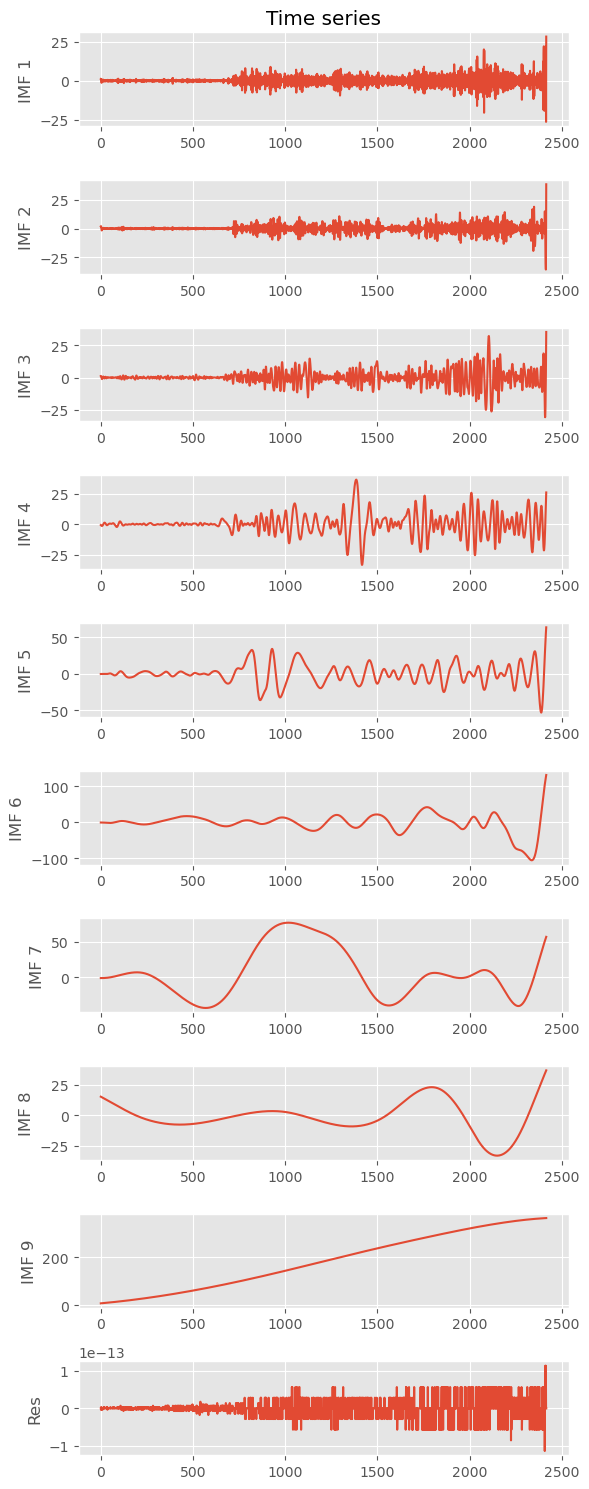

In [7]:
ceemdan = CEEMDAN()
ceemdan.ceemdan(close.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, 2416, 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [97]:
imfs_close[1][2400:2440]

array([ -1.21137127,   0.55431809,   1.16997931,  -1.65432908,
        -4.37287523,  -1.63526761,   7.07444554,  14.95572663,
        14.66387279,   4.70186901, -10.01239794, -23.06808789,
       -31.80786981, -35.8067669 ,  -7.20887658,  38.6173544 ])

In [8]:
# 取之前X_lag个数据来预测下一个数据
def time_slice(data,X_lag):
    sample = []
    label = []
    for k in range(len(data) - X_lag - 1):
        t = k + X_lag
        sample.append(data[k:t])
        label.append(data[t + 1])
    return sample,label


In [9]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

In [10]:
def svr_cv(C, gamma, epsilon, data, targets):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    estimator = SVR(C=C, gamma=gamma, epsilon=epsilon)
    cval = cross_val_score(estimator, data, targets, scoring='explained_variance', cv=4)
    return cval.mean()

In [11]:
def optimize_svr(data, targets):
    """Apply Bayesian Optimization to SVC parameters."""
    def svr_crossval(expC, expGamma, expEpsilon):
        """Wrapper of SVC cross validation.
        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        C = 10 ** expC
        gamma = 10 ** expGamma
        epsilon = 10 ** expEpsilon
        return svr_cv(C=C, gamma=gamma, epsilon=epsilon, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svr_crossval,
        pbounds={"expC": (1e-9, 3), "expGamma": (1e-9, 1), "expEpsilon":(1e-9, 0.1)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)
    
    return optimizer.max

In [12]:
def implement_SVR(X_train, y_train):    
    # 贝叶斯调参
    print(Colours.yellow("--- Optimizing SVM ---"))
    opt = optimize_svr(X_train, y_train)
    
    # train SVR model
    svr = SVR(kernel='rbf', C=opt['params']['expC'], gamma=opt['params']['expGamma'], epsilon=opt['params']['expEpsilon'])
    svr.fit(X_train, y_train)

    return svr

In [93]:
print(np.isnan(X_train).any())
print(np.isinf(X_train).any())
print(np.isnan(y_train).any())
print(np.isinf(y_train).any())

False
False
False
False


In [13]:
i = 1
svr = []
prediction = []
actual = []

for imf in imfs_close:
    print('-'*45)
    print('This is  ' + str(i)  + '  time(s)')
    print('*'*45)
    
    # produce time series dataset
    sample,label = time_slice(imf,30)
    
    # split training and test dataset
    X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    
    # Create standardizer
#     standardizer_x = StandardScaler()
#     standardizer_y = StandardScaler()

    # Fit standardizer to training set
#     standardizer_x.fit(X_train)
#     standardizer_y.fit(y_train)
    
    # Apply to both training and test sets
#     X_train_std = standardizer_x.transform(X_train)
#     X_test_std = standardizer_x.transform(X_test)
#     y_train_std = standardizer_y.transform(y_train)
#     y_test_std = standardizer_y.transform(y_test)


    rbX = RobustScaler()
    X_train_std = rbX.fit_transform(X_train)
    X_test_std = rbX.transform(X_test)

#     rbY = RobustScaler()
#     y_train = np.asarray(y_train)
#     y_train_std = rbY.fit_transform(y_train.reshape(-1,1))
   
    tmp = implement_SVR(X_train_std, y_train)
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test_std)
    prediction.append(pre_tmp)
    
    i=i+1

---------------------------------------------
This is  1  time(s)
*********************************************
--- Optimizing SVM ---
|   iter    |  target   |   expC    | expEps... | expGamma  |
-------------------------------------------------------------
|  1        | -0.000109 |  0.5746   |  0.06221  |  0.4377   |
|  2        | -0.000160 |  2.356    |  0.078    |  0.2726   |
|  3        | -3.919e-0 |  0.8294   |  0.08019  |  0.9581   |
|  4        | -9.039e-0 |  2.628    |  0.03578  |  0.501    |
|  5        | -0.000116 |  2.05     |  0.07127  |  0.3703   |
|  6        | -3.269e-0 |  1.001    |  0.0678   |  0.9862   |
|  7        | -3.021e-0 |  1.293    |  0.09473  |  0.6442   |
|  8        | -4.8e-06  |  1.639    |  0.009731 |  1.0      |
|  9        | -6.104e-0 |  2.987    |  0.01116  |  0.9733   |
|  10       | -2.036e-0 |  1e-09    |  0.1      |  1.0      |
|  11       | -5.166e-0 |  2.357    |  1e-09    |  1.0      |
|  12       | -2.429e-0 |  2.227    |  0.0165   |  0.7878  

|  1        |  0.4804   |  0.5746   |  0.06221  |  0.4377   |
|  2        |  0.766    |  2.356    |  0.078    |  0.2726   |
|  3        |  0.3328   |  0.8294   |  0.08019  |  0.9581   |
|  4        |  0.6633   |  2.628    |  0.03578  |  0.501    |
|  5        |  0.7237   |  2.05     |  0.07127  |  0.3703   |
|  6        |  0.8613   |  3.0      |  0.1      |  1e-09    |
|  7        |  0.8643   |  1.803    |  1e-09    |  1e-09    |
|  8        |  0.8643   |  2.319    |  1e-09    |  1e-09    |
|  9        |  0.8613   |  2.046    |  0.1      |  1e-09    |
|  10       |  0.8613   |  2.657    |  0.1      |  1e-09    |
|  11       |  0.8643   |  2.892    |  1e-09    |  1e-09    |
|  12       |  0.8551   |  1.489    |  0.1      |  1e-09    |
|  13       |  0.8577   |  1.481    |  1e-09    |  1e-09    |
|  14       |  0.8643   |  2.562    |  1e-09    |  1e-09    |
|  15       |  0.8643   |  3.0      |  1e-09    |  1e-09    |
Final result: {'target': 0.8643204656756778, 'params': {'expC': 2.3194

|  4        |  0.9999   |  2.628    |  0.03578  |  0.501    |
|  5        |  0.9999   |  2.05     |  0.07127  |  0.3703   |
|  6        |  0.9999   |  2.118    |  0.1      |  1.0      |
|  7        |  0.9999   |  3.0      |  0.1      |  1e-09    |
|  8        |  0.9999   |  3.0      |  0.1      |  1.0      |
|  9        |  1.0      |  1.867    |  1e-09    |  1e-09    |
|  10       |  0.9999   |  1.555    |  1e-09    |  1.0      |
|  11       |  0.9999   |  3.0      |  1e-09    |  0.4526   |
|  12       |  1.0      |  2.565    |  1e-09    |  1e-09    |
|  13       |  1.0      |  2.155    |  1e-09    |  1e-09    |
|  14       |  0.9999   |  1.656    |  1e-09    |  0.542    |
|  15       |  0.9999   |  2.788    |  1e-09    |  0.2094   |
Final result: {'target': 0.9999530182791903, 'params': {'expC': 2.5648781012445196, 'expEpsilon': 1e-09, 'expGamma': 1e-09}}


In [17]:
sample

[array([-0.3260861 , -0.26037796, -0.19444787, -0.12829597, -0.0619224 ,
         0.0046727 ,  0.0714892 ,  0.13852696,  0.20578585,  0.27326572,
         0.34096643,  0.40888785,  0.47702984,  0.54539227,  0.61397499,
         0.68277787,  0.75180077,  0.82104355,  0.89050608,  0.96018821,
         1.03008981,  1.10021074,  1.17055087,  1.24111006,  1.31188816,
         1.38288504,  1.45410056,  1.5255346 ,  1.59718699,  1.66905762]),
 array([-0.26037796, -0.19444787, -0.12829597, -0.0619224 ,  0.0046727 ,
         0.0714892 ,  0.13852696,  0.20578585,  0.27326572,  0.34096643,
         0.40888785,  0.47702984,  0.54539227,  0.61397499,  0.68277787,
         0.75180077,  0.82104355,  0.89050608,  0.96018821,  1.03008981,
         1.10021074,  1.17055087,  1.24111006,  1.31188816,  1.38288504,
         1.45410056,  1.5255346 ,  1.59718699,  1.66905762,  1.74114634]),
 array([-0.19444787, -0.12829597, -0.0619224 ,  0.0046727 ,  0.0714892 ,
         0.13852696,  0.20578585,  0.27326572, 

In [14]:
svr

[SVR(C=0.0016373366748820097, gamma=2.114652423713608),
 SVR(C=1.5095549664071448, gamma=1e-11),
 SVR(C=0.372895412998103, gamma=1e-11),
 SVR(C=2.810025622627958, gamma=1e-11),
 SVR(C=1.4935735906908052, gamma=1e-11),
 SVR(C=2.1074453197926086, gamma=1e-11),
 SVR(C=2.8457975394300563, gamma=1e-11),
 SVR(C=2.964094894770854, gamma=1e-11),
 SVR(C=3.0, gamma=1.000000082740371e-11)]

In [120]:
prediction

[array([-1.43068994e-01,  7.29071465e-02,  1.88406141e-01,  3.65548812e-01,
         1.15683688e-02, -3.27349186e-03,  3.83213898e-01, -4.51143848e-02,
        -1.80850451e-01,  7.71094424e-03,  4.79410684e-01, -8.66562774e-01,
         7.54045704e-02, -2.52931830e-02,  1.19727887e-01, -7.36314797e-02,
        -3.51890741e-01, -2.81609806e-02, -3.55716756e-01, -4.67807112e-01,
        -1.58306941e-02,  5.68818636e-02, -2.90681401e-01,  6.21289782e-02,
         4.15545617e-01, -7.31314007e-01,  6.56099441e-01, -4.41999161e-01,
        -2.42331662e-01,  5.20844896e-02, -6.48449030e-01,  1.85809977e-03,
         1.53085273e-01, -1.80395991e-01, -2.78085864e-01,  8.12949588e-01,
        -3.34672813e-02,  5.27341918e-01, -4.89500918e-02, -4.04472461e-01,
        -6.33007240e-02,  6.84162855e-01,  4.66664547e-01,  1.75301156e-01,
        -2.98440440e-01,  1.89383300e-01,  5.11903169e-02,  2.11156252e-03,
        -7.21732241e-02,  2.62062513e-01,  2.40585984e-01, -3.39475357e-01,
         3.3

In [111]:
X_test

[array([260.4261379 , 260.50875089, 260.59131707, 260.67383809,
        260.75631565, 260.83875143, 260.92114709, 261.00350431,
        261.08582478, 261.16811017, 261.25036215, 261.33258241,
        261.41477262, 261.49693446, 261.5790696 , 261.66117973,
        261.74326652, 261.82533164, 261.90737678, 261.98940361,
        262.07141381, 262.15340906, 262.23539103, 262.3173614 ,
        262.39932185, 262.48127406, 262.5632197 , 262.64516044,
        262.72709798, 262.80903398]),
 array([262.72709798, 262.80903398, 262.89097012, 262.97290807,
        263.05484953, 263.13679615, 263.21874963, 263.30071164,
        263.38268384, 263.46466794, 263.54666559, 263.62867847,
        263.71070827, 263.79275666, 263.87482532, 263.95691593,
        264.03903015, 264.12116968, 264.20333618, 264.28553134,
        264.36775683, 264.45001433, 264.53230551, 264.61463205,
        264.69699564, 264.77939794, 264.86184064, 264.94432541,
        265.02685393, 265.10942788]),
 array([192.68619872, 192.89

In [14]:
mean_pre = []

for i in range(0,len(prediction[0])):
    sum = 0
    for j in range(0,len(prediction)):
        sum = sum + prediction[j][i]
    
    mean = sum/len(prediction)
    mean_pre.append(mean)
        
mean_pre        

[20.835910779106115,
 20.828375436995927,
 20.77602206641334,
 20.74409388022371,
 20.839695292375946,
 20.73196708389865,
 20.73460342010924,
 20.79118975421096,
 20.745487961337282,
 20.662907505045702,
 20.744382146432894,
 20.744614529844423,
 20.766619240874267,
 20.753306561885957,
 20.724746648648505,
 20.75719163015612,
 20.747123127683825,
 20.74450997358286,
 20.729636302328476,
 20.759545977057783,
 20.75774282326141,
 20.772551725564853,
 20.744437737565406,
 20.719552017803938,
 20.744658770881564,
 20.69166576408781,
 20.74918128770109,
 20.744633157825238,
 20.7458934736605,
 20.743753733184185,
 20.744562389335535,
 20.732118434033065,
 20.73381443023129,
 20.745362955491366,
 20.746884713026095,
 20.74215975996885,
 20.729963331562814,
 20.747678494025095,
 20.766306011924964,
 20.752775862687898,
 20.721166617042343,
 20.743485243107916,
 20.744718136492352,
 20.744560335391395,
 20.74423999149476,
 20.746609417939194,
 20.74463730689066,
 20.80203688054119,
 20.79297

In [15]:
mean_actual = []

for i in range(0,len(actual[0])):
    sum = 0
    for j in range(0,len(actual)):
        sum = sum + actual[j][i]
    
    mean = sum/len(actual)
    mean_actual.append(mean)
        
mean_actual    

[27.657777555555562,
 27.952222999999996,
 24.283333666666667,
 34.30444333333334,
 3.824444222222222,
 3.4788887777777777,
 14.433332666666665,
 25.22333277777778,
 25.001110555555556,
 2.9633333333333334,
 25.19111122222222,
 34.50555422222222,
 25.697777666666667,
 12.804444222222223,
 27.853332555555557,
 3.0733333333333333,
 27.12222288888889,
 24.728888666666666,
 20.418889333333336,
 46.580000111111104,
 3.275555555555555,
 3.7422222222222223,
 35.04444377777777,
 22.807778222222225,
 32.248887777777774,
 40.26333277777778,
 34.58222111111111,
 30.36222333333333,
 25.827777444444443,
 22.307778222222225,
 29.94333222222222,
 2.378888888888889,
 19.69000077777778,
 19.678889,
 26.037777333333327,
 34.89666744444445,
 3.7533332222222224,
 30.55666777777778,
 3.504444555555556,
 27.492221444444446,
 23.34333288888889,
 39.19666544444445,
 25.04444377777778,
 29.718888999999997,
 21.978888666666666,
 27.019999222222225,
 39.82111277777778,
 3.177777777777778,
 24.982221777777777,
 4

In [16]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(mean_actual, mean_pre))
print("mean_squared_error:", mean_squared_error(mean_actual, mean_pre))
print("rmse:", sqrt(mean_squared_error(mean_actual, mean_pre)))
print("r2 score:", r2_score(mean_actual, mean_pre))

mean_absolute_error: 11.470661666767828
mean_squared_error: 181.35991162012274
rmse: 13.46699341427487
r2 score: -0.0008352539713383234


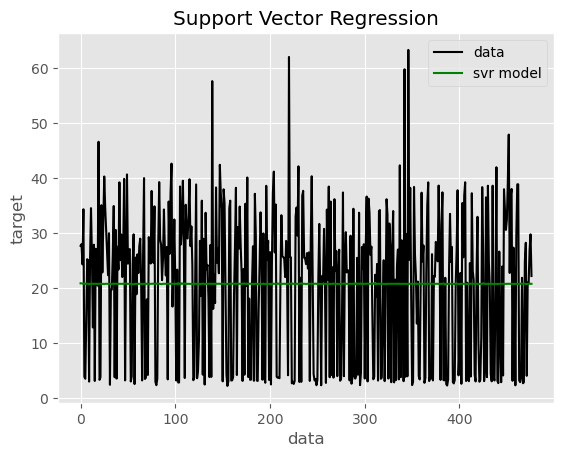

In [17]:
plt.plot(mean_actual,c='k',label='data')
plt.plot(mean_pre,c='g',label='svr model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()
